# OD matrix to Graph tutorial

This notebook demonstrates the conversion of Origin Destination (OD) Matrix into graph. The function `od_matrix_to_graph` supports ODs from `edgelist` (a DataFrame with source, target, and weight columns) and `adjacency` (a square matrix DataFrame or NumPy array). To construct a geospatial graph, it needs the data of `zones_gdf` that contains the information of zones.

## 1. Overview

In this tutorial you will:
- Learn the function inputs and outputs
- Build a tiny mock example (both edgelist and adjacency)
- Build a real graph from London MSOA zones and an ODMG flow table
- Visualize results and optionally convert to NetworkX

## 2. Imports and setup

In [ ]:
# Imports
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import city2graph as c2g
plt.rcParams["figure.figsize"] = (10, 8)

## 3. Edge list
We'll create 4 toy zones laid out in a square, then an edge list with a single weight column.

### Creating sample zones
First, we'll create a simple 4x4 grid of zones to work with. Each zone will be a 1×1 degree square polygon with a unique identifier like "G00", "G10", etc. This gives us 16 zones total that we can reference in our OD data.

In [2]:
# Sixteen zones as a 4x4 grid of square cells (polygons) with explicit ids
from shapely.geometry import box
cells = []
ids = []
# Iterate rows (y) and columns (x) to build 1x1 degree squares
for i in range(4):      # rows (y = 0..3)
    for j in range(4):  # cols (x = 0..3)
        cells.append(box(j, i, j + 1, i + 1))
        ids.append(f"G{j}{i}")  # e.g., G00, G10, ..., G33
zones_gdf = gpd.GeoDataFrame({"zone_id": ids}, geometry=cells, crs="EPSG:4326")
zones_gdf.head()

,zone_id,geometry
0,G00,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))"
1,G10,"POLYGON ((2 0, 2 1, 1 1, 1 0, 2 0))"
2,G20,"POLYGON ((3 0, 3 1, 2 1, 2 0, 3 0))"
3,G30,"POLYGON ((4 0, 4 1, 3 1, 3 0, 4 0))"
4,G01,"POLYGON ((1 1, 1 2, 0 2, 0 1, 1 1))"


### Creating the edge list and converting to graph
Now we'll create a simple edge list DataFrame with source-target pairs and flow values. This represents movement between zones - for example, 5 units flowing from zone G00 to G10. We'll then use `od_matrix_to_graph()` to convert this into spatial graph format.

In [3]:
# Edge list with single weight column using grid zone ids (subset for clarity)
E = pd.DataFrame({
    "source": ["G00", "G00", "G10", "G01", "G22", "G23", "G12"],
    "target": ["G10", "G01", "G11", "G11", "G32", "G33", "G22"],
    "flow":   [5,     2,     3,     7,     4,     6,     5],
})
nodes_gdf1, edges_gdf1 = c2g.od_matrix_to_graph(
    E, zones_gdf, zone_id_col="zone_id",
    matrix_type="edgelist",
    source_col="source", target_col="target",
    weight_cols=["flow"],
    threshold=None,             # drop zeros only
    include_self_loops=False,
    compute_edge_geometry=True,
    directed=True,
    as_nx=False,
 )

/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:137: UserWarning: Geographic CRS detected; distance/length measures may be inaccurate (requirement 3.5)
  _validate_crs(zones_gdf)
/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:1103: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = zones_gdf.geometry.centroid


The function returns two GeoDataFrames: `nodes_gdf1` contains the zone geometries, and `edges_gdf1` contains the flow edges with geometries connecting zone centroids.

In [4]:
edges_gdf1.head()

weight  flow                       geometry
source target                                             
G00    G01          2     2  LINESTRING (0.5 0.5, 0.5 1.5)
       G10          5     5  LINESTRING (0.5 0.5, 1.5 0.5)
G01    G11          7     7  LINESTRING (0.5 1.5, 1.5 1.5)
G10    G11          3     3  LINESTRING (1.5 0.5, 1.5 1.5)
G12    G22          5     5  LINESTRING (1.5 2.5, 2.5 2.5)

### Visualizing the spatial graph
Now let's create a visualization showing both the zone boundaries and the flow edges. The edge thickness will be proportional to the flow weight.

/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_51323/3909391215.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf.centroid.plot(ax=ax, color="#2E86AB", markersize=20, alpha=0.8)


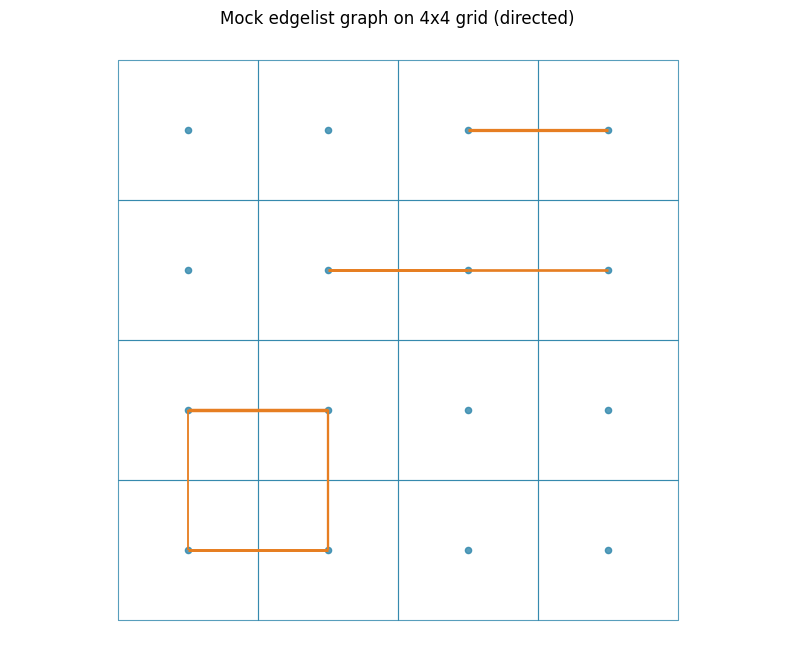

In [5]:
# Quick plot of nodes (grid cells) and edges
ax = zones_gdf.boundary.plot(color="#2E86AB", alpha=0.8, linewidth=0.8)
edges_gdf1.plot(ax=ax, color="#E67E22", linewidth=np.log1p(edges_gdf1["weight"]) * 1.2)
zones_gdf.centroid.plot(ax=ax, color="#2E86AB", markersize=20, alpha=0.8)
plt.title("Mock edgelist graph on 4x4 grid (directed)")
plt.axis("equal"); plt.axis("off")
plt.show()

## 4. Undirected with multiple weights
`od_matrix_to_graph` also supports undirected way of summing flows, and multiple weights. We'll add two weight columns and merge reciprocals by summing. We must choose a `threshold_col` as the primary weight (canonical `weight`).

### Creating an undirected graph with multiple weights
In this example, we'll create edge data with reciprocal pairs (e.g., G00→G10 and G10→G00) and multiple weight columns. When `directed=False`, reciprocal edges are merged by summing their weights.

In [15]:
# Multi-weight undirected example on 4x4 grid (subset of pairs with reciprocals)
E2 = pd.DataFrame({
    "source": ["G00", "G10", "G01", "G11", "G22", "G32", "G23", "G33"],
    "target": ["G10", "G00", "G11", "G01", "G32", "G22", "G33", "G23"],
    "trips":  [5,     1,     7,     2,     4,     3,     8,     2],
    "cost":   [10,    2,     12,    3,     7,     4,     15,    3],
})
nodes_gdf2, edges_gdf2 = c2g.od_matrix_to_graph(
    E2, zones_gdf, zone_id_col="zone_id",
    matrix_type="edgelist",
    source_col="source", target_col="target",
    weight_cols=["trips", "cost"],
    threshold=3, threshold_col="trips",
    include_self_loops=False,
    compute_edge_geometry=True,
    directed=False,  # undirected: sum reciprocals
    as_nx=False,
 )

/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:137: UserWarning: Geographic CRS detected; distance/length measures may be inaccurate (requirement 3.5)
  _validate_crs(zones_gdf)
/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:1103: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = zones_gdf.geometry.centroid


### Plotting the undirected graph
The visualization will show the merged edges with their combined weights. Notice how reciprocal flows are now represented as single undirected edges.

/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_51323/133846062.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf.centroid.plot(ax=ax, color="#2E86AB", markersize=20, alpha=0.8)


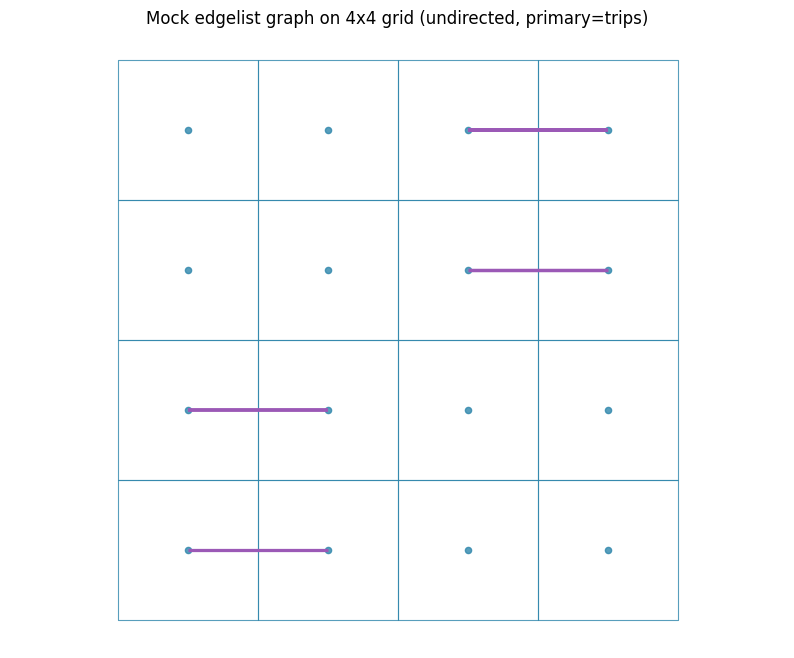

In [16]:
ax = zones_gdf.boundary.plot(color="#2E86AB", alpha=0.8, linewidth=0.8)
edges_gdf2.plot(ax=ax, color="#9B59B6", linewidth=np.log1p(edges_gdf2["weight"]) * 1.2)
zones_gdf.centroid.plot(ax=ax, color="#2E86AB", markersize=20, alpha=0.8)
plt.title("Mock edgelist graph on 4x4 grid (undirected, primary=trips)")
plt.axis("equal"); plt.axis("off")
plt.show()

## 5. Adjacency matrix
You can pass a square pandas DataFrame (index and columns must match) or a NumPy array.

### Building an adjacency matrix
Instead of an edge list, we can provide data as an adjacency matrix. Here we'll create a 16×16 DataFrame where rows and columns represent zones, and cell values represent flows.

In [8]:
# Build an adjacency DataFrame matching the 4x4 grid zone ids
ids = zones_gdf["zone_id"]
# Create a sparse 16x16 matrix with a few flows
A = pd.DataFrame(0, index=ids, columns=ids, dtype=float)
# add some directed flows
A.loc["G00", "G10"] = 5
A.loc["G00", "G01"] = 2
A.loc["G10", "G11"] = 3
A.loc["G01", "G11"] = 7
A.loc["G22", "G32"] = 4
A.loc["G23", "G33"] = 6
A.loc["G12", "G22"] = 5
nodes_gdf3, edges_gdf3 = c2g.od_matrix_to_graph(
    A, zones_gdf, zone_id_col="zone_id",
    matrix_type="adjacency",
    include_self_loops=False,
    threshold=None,
    directed=True,
 )

/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:137: UserWarning: Geographic CRS detected; distance/length measures may be inaccurate (requirement 3.5)
  _validate_crs(zones_gdf)
/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:1103: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = zones_gdf.geometry.centroid


### Visualizing the adjacency matrix graph
The result should be identical to our first example since we're using the same flow values, just in matrix format instead of edge list format.

/var/folders/_n/l2f9tkgn3g17dj7hnsjprssc0000gn/T/ipykernel_51323/2081733941.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_gdf.centroid.plot(ax=ax, color="#2E86AB", markersize=20, alpha=0.8)


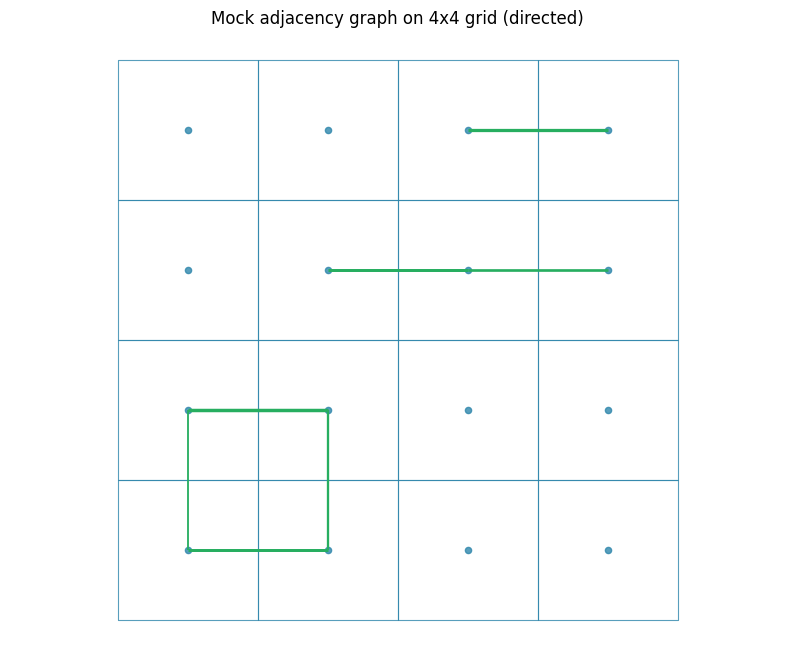

In [9]:
ax = zones_gdf.boundary.plot(color="#2E86AB", alpha=0.8, linewidth=0.8)
edges_gdf3.plot(ax=ax, color="#27AE60", linewidth=np.log1p(edges_gdf3["weight"]) * 1.2)
zones_gdf.centroid.plot(ax=ax, color="#2E86AB", markersize=20, alpha=0.8)
plt.title("Mock adjacency graph on 4x4 grid (directed)")
plt.axis("equal"); plt.axis("off")
plt.show()

## 6. London MSOA example
This section mirrors the development notebook and uses local files under `dev/`. You can adjust paths as needed.

### Loading real-world data
Now we'll work with actual migration data from the UK Office for National Statistics .  For the dataset, we employed the OD data of England and Wales from the [UK Census 2021](https://www.nomisweb.co.uk/sources/census_2021_od). We'll load [MSOA (Middle Layer Super Output Areas) zone boundaries](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates) for the zone unit.

In [10]:
# Paths (adjust to your environment if needed)
# Relative to repository root
ZONE_GPKG = "../../../dev/Middle_layer_Super_Output_Areas_December_2021_Boundaries_EW_BGC_V3_-1334546435986816930.gpkg"
OD_CSV   = "../../../dev/odmg/odmg01ew/ODMG01EW_MSOA.csv"

zones_london = gpd.read_file(ZONE_GPKG)
od_london = pd.read_csv(OD_CSV)
print(f"zones_london: {len(zones_london)} rows, CRS={zones_london.crs}")
od_london.head(3)

zones_london: 7264 rows, CRS=EPSG:27700


,Migrant MSOA one year ago code,Migrant MSOA one year ago label,Middle layer Super Output Areas code,Middle layer Super Output Areas label,Count
0,-8,Does not apply,E02000001,City of London 001,6237
1,-8,Does not apply,E02000002,Barking and Dagenham 001,7622
2,-8,Does not apply,E02000003,Barking and Dagenham 002,10285


### Converting London migration data to graph
The ODMG dataset has specific column names for the migration data. We'll map these to our function parameters and create an undirected graph to represent bidirectional migration flows.

In [11]:
# Column mapping for ODMG dataset
source_col = "Migrant MSOA one year ago code"
target_col = "Middle layer Super Output Areas code"
weight_col = "Count"
zone_id_col = "MSOA21CD"

od_nodes, od_edges = c2g.od_matrix_to_graph(
    od_london, zones_london, zone_id_col=zone_id_col,
    matrix_type="edgelist",
    source_col=source_col, target_col=target_col,
    weight_cols=[weight_col],
    threshold=None,
    include_self_loops=False,
    compute_edge_geometry=True,
    directed=False,
    as_nx=False,
 )
len(od_nodes), len(od_edges)

/Users/yutasato/Projects/Liverpool/city2graph/city2graph/mobility.py:175: UserWarning: Dropped 36661 edges referencing unknown zone IDs (requirement 3.6)
  aligned = _align_edgelist_zones(


(7264, 1228547)

### Inspecting the London graph structure
Let's examine the structure of our London migration network to understand what we've created.

In [12]:
# Inspect a few rows
od_nodes.head()

,MSOA21CD,MSOA21NM,MSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry
MSOA21CD,,,,,,,,,
E02000001,E02000001,City of London 001,,532384,181355,51.515621,-0.093490,{71249043-B176-4306-BA6C-D1A993B1B741},"MULTIPOLYGON (((532135.138 182198.131, 532071...."
E02000002,E02000002,Barking and Dagenham 001,,548267,189685,51.586521,0.138756,{997A80A8-0EBE-461C-91EB-3E4122571A6E},"MULTIPOLYGON (((548881.563 190845.265, 548845...."
E02000003,E02000003,Barking and Dagenham 002,,548259,188520,51.576061,0.138149,{62DED9D9-F53A-454D-AF35-04404D9DBE9B},"MULTIPOLYGON (((549102.438 189324.625, 549120...."
E02000004,E02000004,Barking and Dagenham 003,,551004,186412,51.556389,0.176828,{511181CD-E71F-4C63-81EE-E8E76744A627},"MULTIPOLYGON (((551550.056 187364.705, 551551...."
E02000005,E02000005,Barking and Dagenham 004,,548733,186824,51.560692,0.144267,{B0C823EB-69E0-4AE7-9E1C-37715CF3FE87},"MULTIPOLYGON (((549099.634 187656.076, 549057...."


In [13]:
od_edges.head()

weight  Count  \
source    target                     
E02000001 E02000012       1      1   
          E02000024       1      1   
          E02000029       1      1   
          E02000030       1      1   
          E02000035       3      3   

                                                              geometry  
source    target                                                        
E02000001 E02000012  LINESTRING (532485.482 181271.782, 545635.991 ...  
          E02000024  LINESTRING (532485.482 181271.782, 524413.978 ...  
          E02000029  LINESTRING (532485.482 181271.782, 527246.245 ...  
          E02000030  LINESTRING (532485.482 181271.782, 522736.368 ...  
          E02000035  LINESTRING (532485.482 181271.782, 525825.887 ...

### Calculating Network centrality

In [17]:
G = c2g.gdf_to_nx(od_nodes, od_edges)

In [19]:
# Calculate centralities
degree_centrality = nx.degree_centrality(G)

# Set as node attributes
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

In [20]:
od_nodes, od_edges = c2g.nx_to_gdf(G)

In [22]:
od_nodes.head()

,MSOA21CD,MSOA21NM,MSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,degree_centrality
MSOA21CD,,,,,,,,,,
E02000001,E02000001,City of London 001,,532384,181355,51.515621,-0.093490,{71249043-B176-4306-BA6C-D1A993B1B741},"MULTIPOLYGON (((532135.138 182198.131, 532071....",0.116205
E02000002,E02000002,Barking and Dagenham 001,,548267,189685,51.586521,0.138756,{997A80A8-0EBE-461C-91EB-3E4122571A6E},"MULTIPOLYGON (((548881.563 190845.265, 548845....",0.039928
E02000003,E02000003,Barking and Dagenham 002,,548259,188520,51.576061,0.138149,{62DED9D9-F53A-454D-AF35-04404D9DBE9B},"MULTIPOLYGON (((549102.438 189324.625, 549120....",0.061683
E02000004,E02000004,Barking and Dagenham 003,,551004,186412,51.556389,0.176828,{511181CD-E71F-4C63-81EE-E8E76744A627},"MULTIPOLYGON (((551550.056 187364.705, 551551....",0.042269
E02000005,E02000005,Barking and Dagenham 004,,548733,186824,51.560692,0.144267,{B0C823EB-69E0-4AE7-9E1C-37715CF3FE87},"MULTIPOLYGON (((549099.634 187656.076, 549057....",0.055349


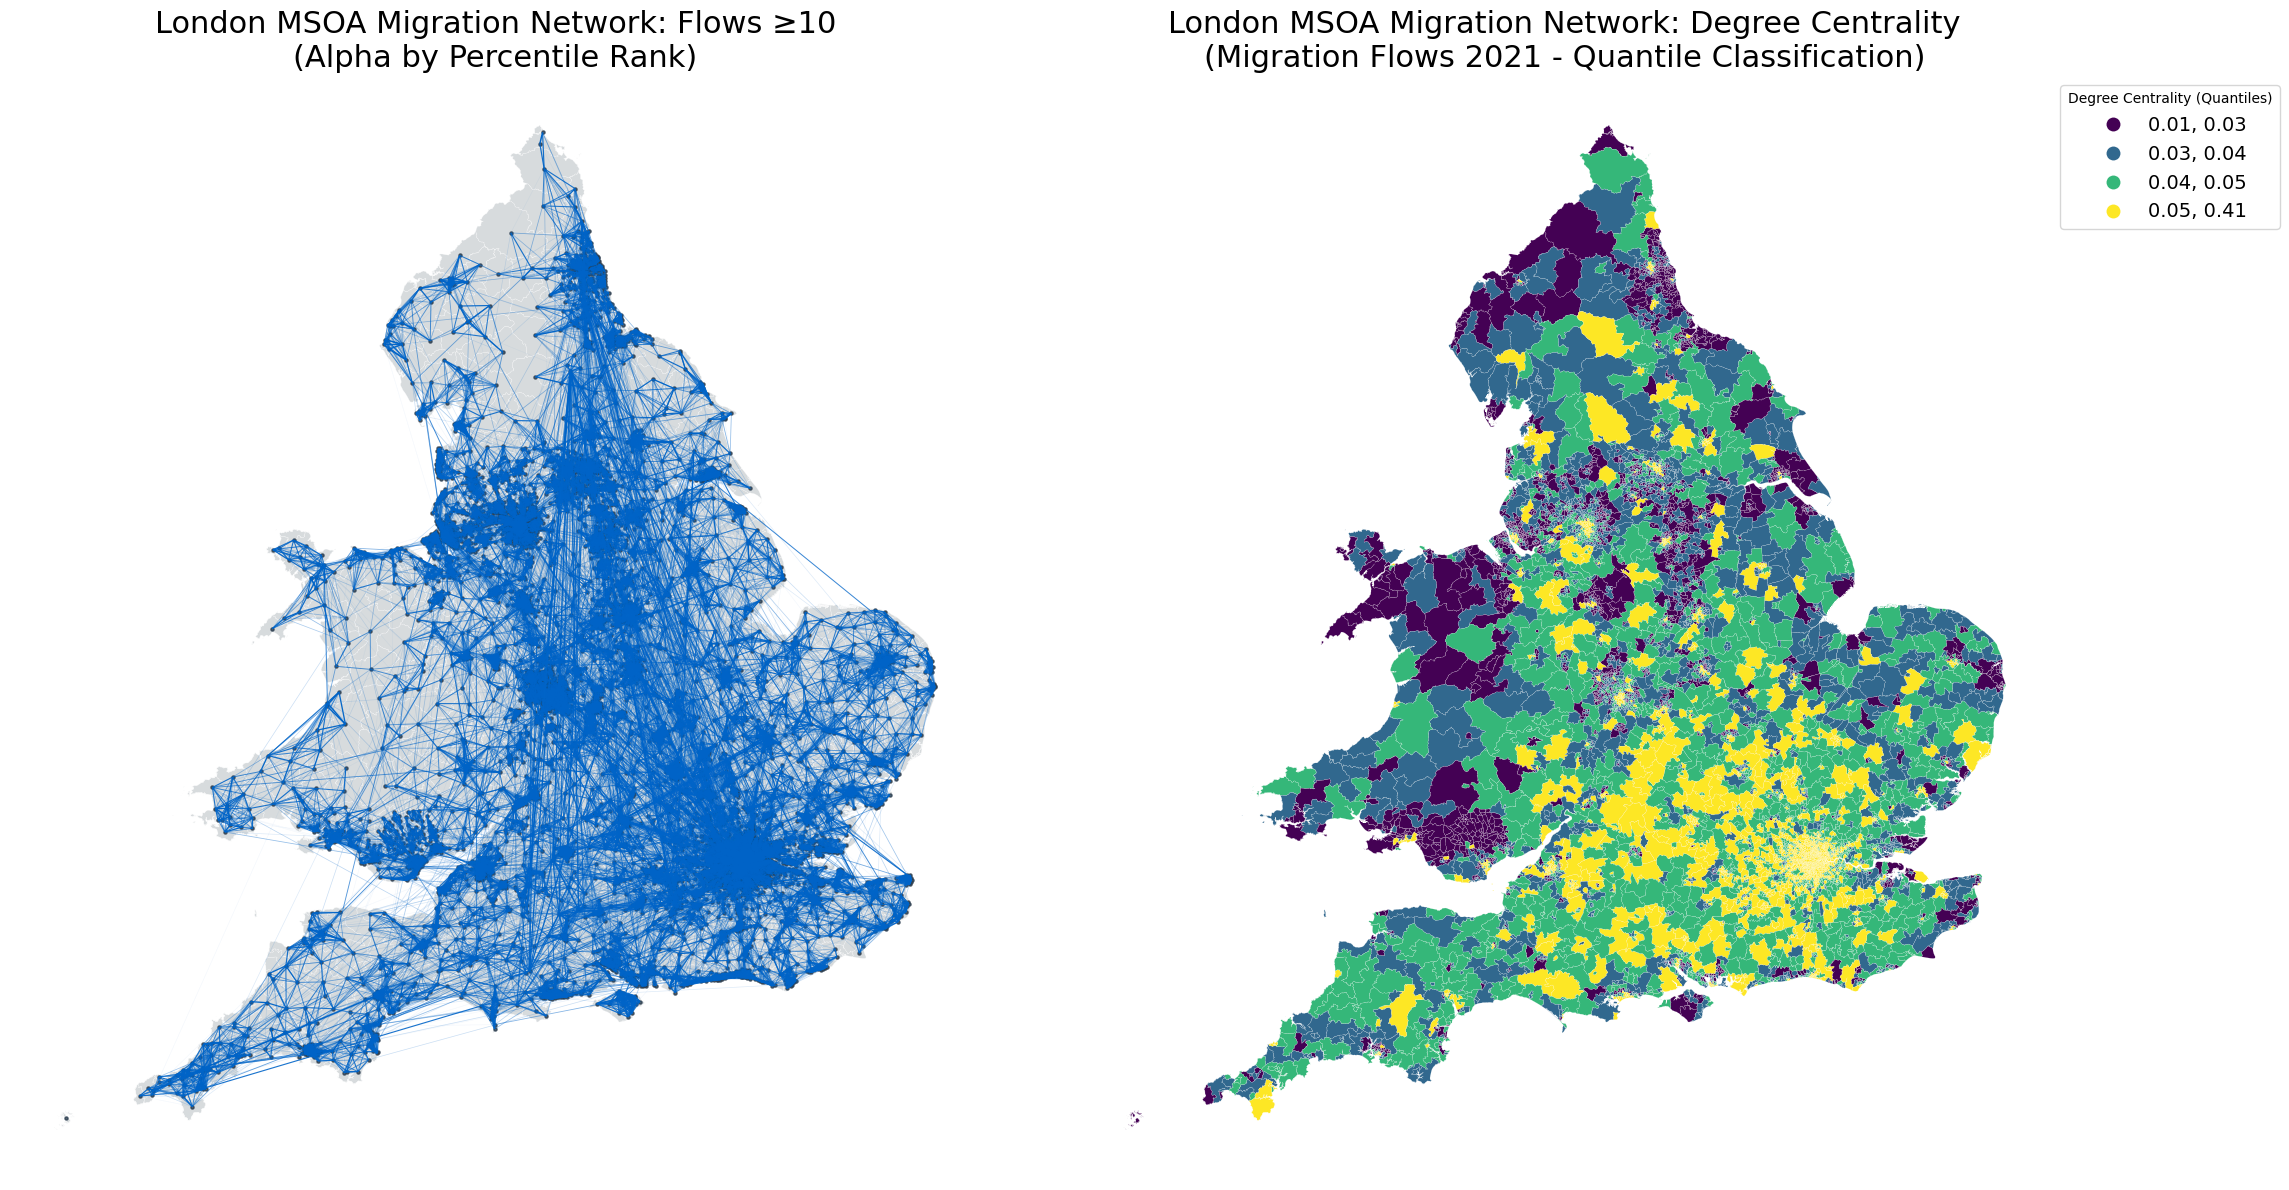

In [43]:
from matplotlib.collections import LineCollection

# Filter for flows >= 10
top_edges = od_edges[od_edges[weight_col] >= 10]

# Compute percentile ranks for weights
percentile_ranks = top_edges[weight_col].rank(pct=True)

# Normalize alpha values based on percentile ranks
alpha_values = percentile_ranks

# Create subplots: left for network, right for degree centrality
fig, axs = plt.subplots(1, 2, figsize=(24, 12))

# Left subplot: Network visualization
axs[0].set_title("London MSOA Migration Network: Flows ≥10\n(Alpha by Percentile Rank)", fontsize=22)
zones_london.plot(ax=axs[0], color="#BDC3C7", edgecolor="white", linewidth=0.3, alpha=0.6)

# Convert LineString geometries to coordinate lists for LineCollection
lines = [list(line.coords) for line in top_edges.geometry]
colors = [(0/255, 100/255, 200/255, alpha) for alpha in alpha_values]  # Blue base color with alpha
linewidths = np.log1p(top_edges[weight_col]) * 0.2
lc = LineCollection(lines, colors=colors, linewidths=linewidths)
axs[0].add_collection(lc)

zones_london.centroid.plot(ax=axs[0], color="#2C3E50", markersize=5, alpha=0.8)
axs[0].set_axis_off()

# Right subplot: Degree centrality
axs[1].set_title("London MSOA Migration Network: Degree Centrality\n(Migration Flows 2021 - Quantile Classification)", fontsize=22)
od_nodes.plot(
    column='degree_centrality', 
    ax=axs[1], 
    cmap='viridis',
    edgecolor='white', 
    linewidth=0.1,
    legend=True,
    scheme='quantiles',
    k=4,
    legend_kwds={'title': 'Degree Centrality (Quantiles)', 'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 14}
)
axs[1].set_axis_off()
axs[1].set_facecolor('#f8f9fa')

plt.tight_layout()
plt.show()
